# Multi-layer perceptron name generator

## Data preprocessing

First, let's import our dependencies:

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

Now we import our dataset:

In [25]:
df = pd.read_csv("datasets/names/yob1999.csv", header=None)
# Cool idea: maybe weight this by frequency somehow?
df.columns = ["name", "gender", "count"]
df.head()

,name,gender,count
0,Emily,F,26539
1,Hannah,F,21677
2,Alexis,F,19234
3,Sarah,F,19112
4,Samantha,F,19040


We reprise our data cleaning steps from earlier:

In [26]:
# Just for today, 2023-02-22
df = df[df["gender"] == "F"]
df["name"] = df["name"].str.lower()
df

,name,gender,count
0,emily,F,26539
1,hannah,F,21677
2,alexis,F,19234
3,sarah,F,19112
4,samantha,F,19040
...,...,...,...
16939,zohal,F,5
16940,zophia,F,5
16941,zuha,F,5
16942,zuhal,F,5


Now we break up the names such that we get the preceding three chars (or ".") in one col and the char itself in another:

In [27]:
test_name = "cathey"
def split_name(name):
    pairs = []
    for idx, char in enumerate(name):
        triple = (name[max(0, idx-3):idx].rjust(3, '.'))
        pairs.append((char, triple))

    pairs.append(('.', name[max(0, len(name) - 3):].rjust(3, '.')))
    return(pairs)

split_name(test_name)

[('c', '...'),
 ('a', '..c'),
 ('t', '.ca'),
 ('h', 'cat'),
 ('e', 'ath'),
 ('y', 'the'),
 ('.', 'hey')]

We apply this to all names:

In [28]:
df["pairs"] = df["name"].apply(split_name)
df = df.explode("pairs")
df

,name,gender,count,pairs
0,emily,F,26539,"(e, ...)"
0,emily,F,26539,"(m, ..e)"
0,emily,F,26539,"(i, .em)"
0,emily,F,26539,"(l, emi)"
0,emily,F,26539,"(y, mil)"
...,...,...,...,...
16943,zuzu,F,5,"(z, ...)"
16943,zuzu,F,5,"(u, ..z)"
16943,zuzu,F,5,"(z, .zu)"
16943,zuzu,F,5,"(u, zuz)"


In [29]:
foo = pd.DataFrame(df['pairs'].apply(lambda p: list(p)), index=df.index)
data = pd.DataFrame(foo['pairs'].tolist(), columns=["label", "triple"])
data

,label,triple
0,e,...
1,m,..e
2,i,.em
3,l,emi
4,y,mil
...,...,...
124356,z,...
124357,u,..z
124358,z,.zu
124359,u,zuz


In [30]:
df_old = df
df = data

Finally, we make this into tensors:

In [31]:
def char2idx(c):
    # Assumes valid input
    if c == ".":
        return 0
    else:
        return ord(c) - ord("a") + 1

def idx2char(i):
    if i == 0:
        return ""
    elif i < 28:
        return(chr(i+ord("a")-1))
    else:
        return("ERR")

df["label_int"] = df['label'].apply(char2idx)
labels = F.one_hot(torch.tensor(df["label_int"]), 27)
contexts = torch.tensor(df["triple"].apply(lambda t: list(map(char2idx, t))))

Finally, we put this into a *bona fide* PyTorch dataset:

In [32]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(contexts, labels)

train_size = int(0.8 * len(contexts))
test_size = len(contexts) - train_size
train_len = int(train_size / len(dataset) * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset= torch.utils.data.random_split(dataset, [train_len,test_len])

## Model setup

### Embed

Now that we have `contexts` and `labels` properly constructed, let's construct the embedding layer.

We embed the *output classes*: 27 chars, in 2 dimensions.

In [33]:
# Name could be better
EMBEDDING_NDIM = 2
C = torch.randn(27, EMBEDDING_NDIM)
C.shape

torch.Size([27, 2])

We can index into a tensor in **multiple dimensions**, which can effectively "index for all" if given another tensor to index in. This way, we can convert *all* our input "context" of 3 chars into embeddings.

In [34]:
# We can index into a tensor **mu
emb = C[contexts]

### Hidden layer

Our "hidden layer" is an arbitrary set of neurons between the input embedding and the target extraction. Let's init:

In [35]:
HIDDEN_NDIM = 100
W1 = torch.randn(6, HIDDEN_NDIM, requires_grad=True)
b1 = torch.randn(HIDDEN_NDIM, requires_grad=True)

We can "index into" this tensor to get our stuff:

In [36]:
# TODO: SRS this
foo = emb.view(-1, 6)
(foo @ W1).shape

torch.Size([124361, 100])

A standard activation would be as follows:

In [37]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([124361, 100])

Finally, as in any other classification problem, we translate from this hidden layer to our output layer:

In [38]:
W2 = torch.randn(HIDDEN_NDIM, 27, requires_grad=True)
B2 = torch.randn(27, requires_grad=True)

Our loss function is the same as many other classification problems: plain old cross-entropy loss again.

## Training loop

I'm just going to write out the entire MLP class at once. This is terrible, but my laziness and depression have forced my hand.

### Batch normalization

Intuitively, what we're trying to do is to manually "normalize" the whole batch activations to be like the normal distribution around 0.

How we accomplish this:
- Kill bias layer in middle
- Keep running mean and stdev of batch, which we (somewhat arbitrarily) set to update by 1e-3 each cycle
- Subtract mean and divide by the standard deviation
- Add learned bias?

In [102]:
class MLP:
    def __init__(self, embedding_size, hidden_size):
        self.embedding_size = embedding_size
        self.C = torch.randn(27, embedding_size)

        # Hidden layer
        self.W1 = torch.empty(3 * embedding_size, hidden_size)
        nn.init.kaiming_normal_(self.W1, nonlinearity="tanh")
        #self.B1 = torch.randn(hidden_size) * 1e-4
        self.Gamma1 = torch.randn(hidden_size) * 1e-1
        self.Beta1 = torch.randn(hidden_size) * 1e-4 

        # Output layer
        self.W2 = torch.randn(hidden_size, 27) * 1e-1
        self.B2 = torch.randn(27) * 1e-4
        self.parameters = [self.C, self.W1, self.Gamma1, self.Beta1, self.W2, self.B2]
        for p in self.parameters:
            p.requires_grad = True

        # Batch norm setup
        self.running_mean = 0
        self.running_stdev = 1
    
    def infer(self, x):
        """Returns logits for future use"""
        with torch.no_grad():
            emb = self.C[x]
            hidden_layer_output = torch.tanh(emb.view(-1,3 * self.embedding_size) @ self.W1)
            hidden_layer_norm = torch.mul((hidden_layer_output - self.running_mean) / self.running_stdev, self.Gamma1) + self.Beta1
            logits = hidden_layer_norm @ self.W2 + self.B2
            return(logits)

    def forward(self, x):
        """Takes batch of contexts; returns logits"""
        # Embed batch
        emb = self.C[x]
        # Run hidden layer; apply nonlinearity; batch normalize
        hidden_layer_output = torch.tanh(emb.view(-1,3 * self.embedding_size) @ self.W1)
        hidden_layer_norm = self.Gamma1 * (hidden_layer_output - hidden_layer_output.mean(0, keepdim=True)) / hidden_layer_output.std(0, keepdim=True) + self.Beta1
        with torch.no_grad():
            DECAY = 1e-3
            self.running_mean = (1-DECAY) * self.running_mean + (DECAY) * torch.mean(hidden_layer_output)
            self.running_stdev = (1-DECAY) * self.running_stdev + (DECAY) * torch.std(hidden_layer_output)

        # Final layer: crunch down to output logits
        logits = hidden_layer_norm @ self.W2 + self.B2
        return(logits)

    def backward(self, x, y_true):
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y_true)

        # Zero out gradients
        for p in self.parameters:
            p.grad = None

        loss.backward()
        print(f"Loss: {loss.item()}")
        return loss
    
    def update_parameters(self, lr):
        # Subtract the gradients
        with torch.no_grad():
            # There HAS to be a better way to do this
            for p in self.parameters:
                p.data -= lr * p.grad

    def fit_one_cycle(self, x, y_true, lr):
        self.backward(x, y_true)
        self.update_parameters(lr)
    


Now it merely falls to us to write the driver code:

In [103]:
BATCH_SIZE = 16
EMBEDDING_NDIM = 5
HIDDEN_NDIM = 50
STEPS=10000

# Simple exponential decay
lrs = 10 ** np.linspace(0, -3, STEPS + 1)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
model = MLP(EMBEDDING_NDIM, HIDDEN_NDIM)

global_step = 0
epoch = 0
while global_step < STEPS:
    for step, (data, labels) in enumerate(train_dataloader):
        print(f"Step {global_step}:")
        model.fit_one_cycle(data, labels.float(), lrs[step])

        global_step += 1
        if global_step >= STEPS:
            break
    epoch += 1
    if global_step >= STEPS:
        break


Step 0:
Loss: 3.2795493602752686
Step 1:
Loss: 3.282184362411499
Step 2:
Loss: 3.2081804275512695
Step 3:
Loss: 3.1162936687469482
Step 4:
Loss: 3.1434404850006104
Step 5:
Loss: 3.0153775215148926
Step 6:
Loss: 2.978940963745117
Step 7:
Loss: 3.1653170585632324
Step 8:
Loss: 2.9737436771392822
Step 9:
Loss: 3.1229681968688965
Step 10:
Loss: 2.8577170372009277
Step 11:
Loss: 2.8505072593688965
Step 12:
Loss: 2.6333117485046387
Step 13:
Loss: 2.8333749771118164
Step 14:
Loss: 2.596050977706909
Step 15:
Loss: 2.692201614379883
Step 16:
Loss: 2.742772102355957
Step 17:
Loss: 3.4358773231506348
Step 18:
Loss: 2.678574562072754
Step 19:
Loss: 2.825331687927246
Step 20:
Loss: 2.867581605911255
Step 21:
Loss: 3.01842999458313
Step 22:
Loss: 2.944365978240967
Step 23:
Loss: 2.762953042984009
Step 24:
Loss: 2.868251323699951
Step 25:
Loss: 2.5128660202026367
Step 26:
Loss: 2.590178966522217
Step 27:
Loss: 2.8748583793640137
Step 28:
Loss: 3.1218554973602295
Step 29:
Loss: 2.634368419647217
Step 

After some tinkering, we find that small batch sizes (8), linear decay LR from 0.5 to 1e-2, and higher steps decrease rate (severe overfitting begins...)
Finally, we get the loss on the training set (we technically need a validation, but I can't be bothered):

In [104]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_loss = 0
for data, labels in test_dataloader:
    loss = model.backward(data, labels.float())


Loss: 2.1719954013824463


In [98]:
model.running_stdev

tensor(0.8726, grad_fn=<AddBackward0>)

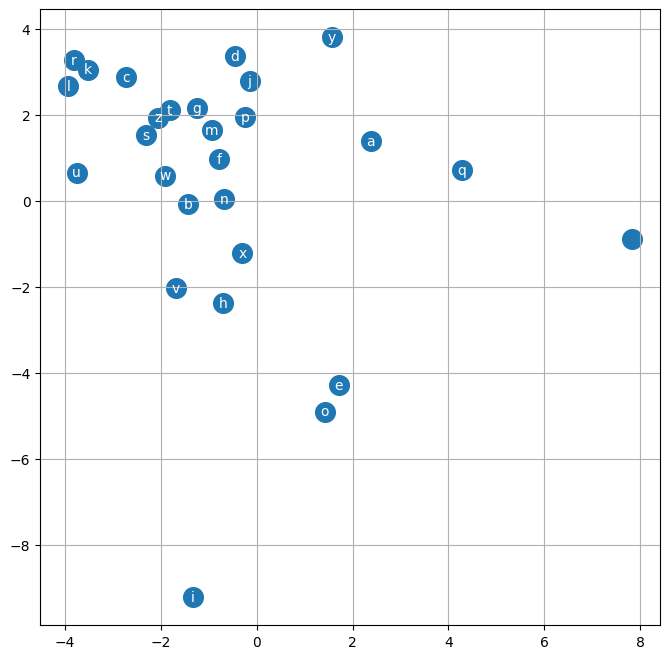

In [222]:
model.plot_embeddings()

## Generation

In [99]:
g = torch.Generator()

for _ in range(20):
    out = []
    context = [0,0,0]
    while True:
        logits = model.infer(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # randomly sample pred from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(idx2char(i) for i in out))

trinlei
shevia
cha
wia
jalon
melle
niva
janellan
mavi
deanna
mabete
stelyn
gran
zicfanza
kra
sona
kvcennnnn
vayza
jamblyn
jal


## Testing and validation

### Finding the learning rate

This hyperparameter is kind of important (citation needed). To start, we want to implement something like the "learning rate finder", where we exponentially increase lr until we hit a wall and then find it somewhere around there. Let's give it a try! Let's go from $10^{-3}$ to $10^1$ in increments of 2x???

In [60]:
lr_model = MLP(EMBEDDING_NDIM, HIDDEN_NDIM)
lr = 10e-4

# WHY IS THIS LANGUAGE NOT TYPED AARGH
losses = []
i = 0

while lr < 10:
    start, end = i * BATCH_SIZE, (i+1) * BATCH_SIZE
    loss = lr_model.backward(contexts[start:end], labels[start:end].float())
    lr_model.update_parameters(lr)
    losses.append({"loss" : loss.item(), "lr": lr})
    lr *= 1.05
    i+=1

loss_df = pd.DataFrame.from_records(losses)
loss_df["loss_smooth"] = loss_df["loss"].rolling(window=5).mean()

Loss: 7.430624008178711
Loss: 5.907592296600342
Loss: 6.736423969268799
Loss: 6.276147842407227
Loss: 8.191972732543945
Loss: 6.006835460662842
Loss: 7.029684066772461
Loss: 5.80147647857666
Loss: 6.876686096191406
Loss: 6.443017482757568
Loss: 6.2708916664123535
Loss: 5.996418476104736
Loss: 6.9694013595581055
Loss: 7.181060314178467
Loss: 7.285386562347412
Loss: 6.76036262512207
Loss: 4.900427341461182
Loss: 6.592562198638916
Loss: 7.163669586181641
Loss: 6.860597133636475
Loss: 6.350022315979004
Loss: 6.802441120147705
Loss: 5.725580215454102
Loss: 6.045586109161377
Loss: 7.162632465362549
Loss: 6.112359046936035
Loss: 6.745479106903076
Loss: 8.428348541259766
Loss: 7.566260814666748
Loss: 7.213047027587891
Loss: 6.1751508712768555
Loss: 6.329876899719238
Loss: 5.869903087615967
Loss: 6.829679489135742
Loss: 7.537769317626953
Loss: 6.489545822143555
Loss: 6.2317705154418945
Loss: 6.0110626220703125
Loss: 7.265320301055908
Loss: 8.121577262878418
Loss: 6.227502822875977
Loss: 6.25087

Now let's graph this:

In [53]:
import matplotlib.pyplot as plt

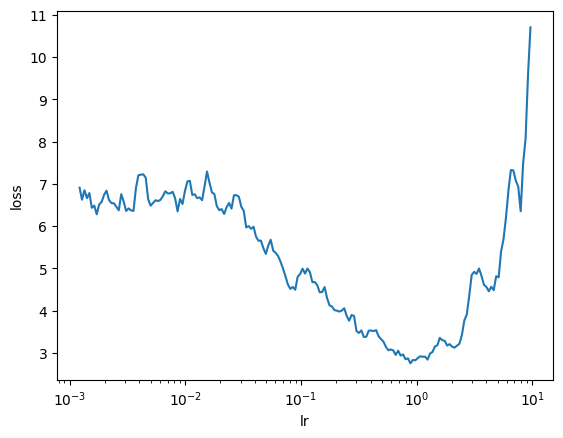

In [61]:
plt.plot(loss_df['lr'], loss_df['loss_smooth'])
plt.xscale('log')
plt.xlabel('lr')
plt.ylabel('loss')
plt.show()


Looks like our initial learning rate wasn't aggressive enough! torch.linspace, -3, 0 10** that. instead of what we did here

## Generation